In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/bstadt-tlm/tlm/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

In [2]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [3]:
year_embeddings = []
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
# Get the vocab matrix row for each year_fill_token_id
# This is typically the embedding layer's weight matrix
embedding_matrix = model.get_input_embeddings().weight.detach().cpu()
for token_id in year_fill_token_ids:
    year_embeddings.append(embedding_matrix[token_id])



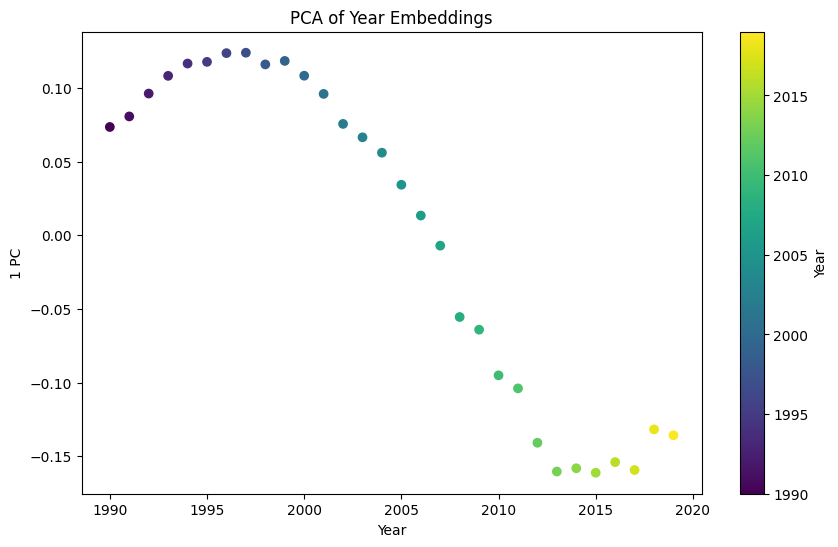

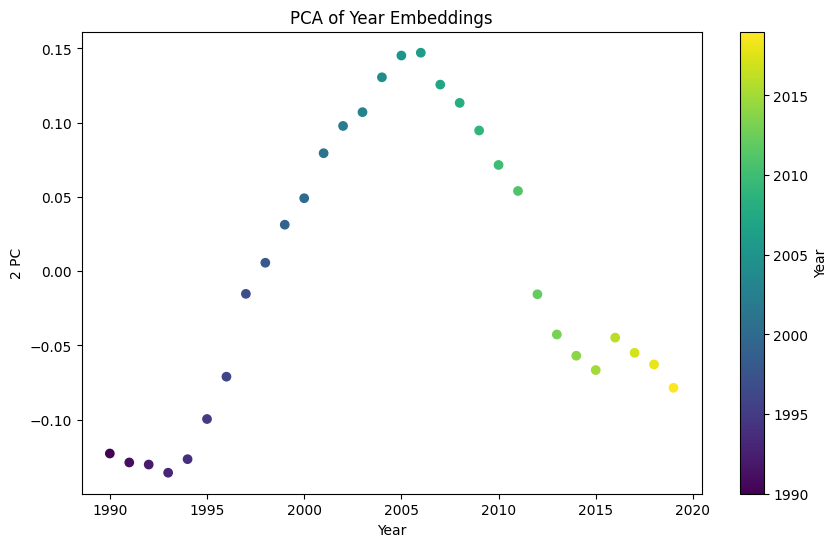

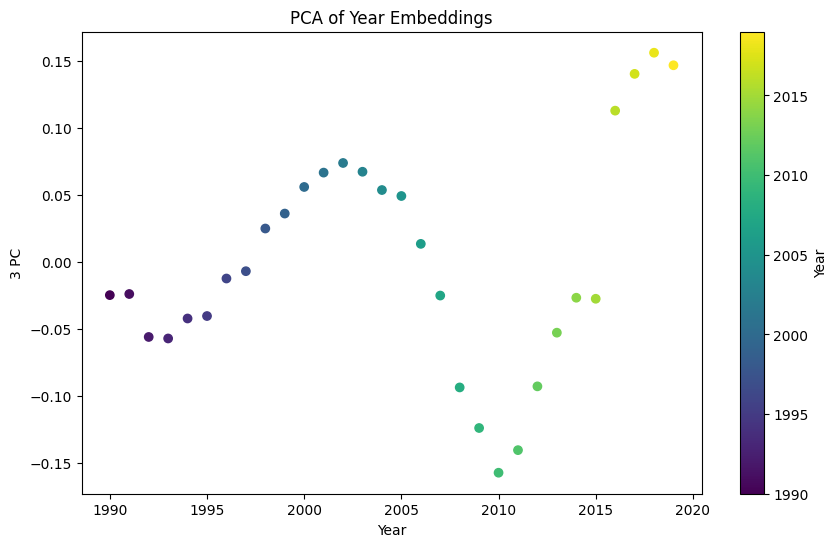

In [5]:
import numpy as np
from matplotlib import pyplot as plt
# Convert to numpy array
year_matrix = np.stack(year_embeddings)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
year_pca = pca.fit_transform(year_matrix)

for i in range(3):
    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(years, year_pca[:, i], c=range(1990, 2020), cmap='viridis')
    plt.colorbar(label='Year')
    plt.xlabel('Year')
    plt.ylabel('{} PC'.format(i+1))
    plt.title('PCA of Year Embeddings')
    plt.show()

import plotly.graph_objs as go

fig = go.Figure(data=[go.Scatter3d(
    x=year_pca[:, 0],
    y=year_pca[:, 1],
    z=year_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=years,
        colorscale='Viridis',
        colorbar=dict(title='Year'),
        opacity=0.8
    ),
    text=[str(year) for year in years],
    textposition='top center'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Interactive 3D PCA of Year Embeddings',
    width=1000,
    height=600
)
fig.show()


In [6]:


import plotly.io as pio

fig = go.Figure(data=[go.Scatter3d(
    x=year_pca[:, 0],
    y=year_pca[:, 1],
    z=year_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=years,
        colorscale='Viridis',
        colorbar=dict(title='Year'),
        opacity=0.8
    ),
    text=[str(year) for year in years],
    textposition='top center'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Interactive 3D PCA of Year Embeddings',
    width=1000,
    height=600
)

# Export the plot as HTML
pio.write_html(fig, file="year_pca_3d.html", auto_open=False)

# Optionally, still show in notebook
fig.show()


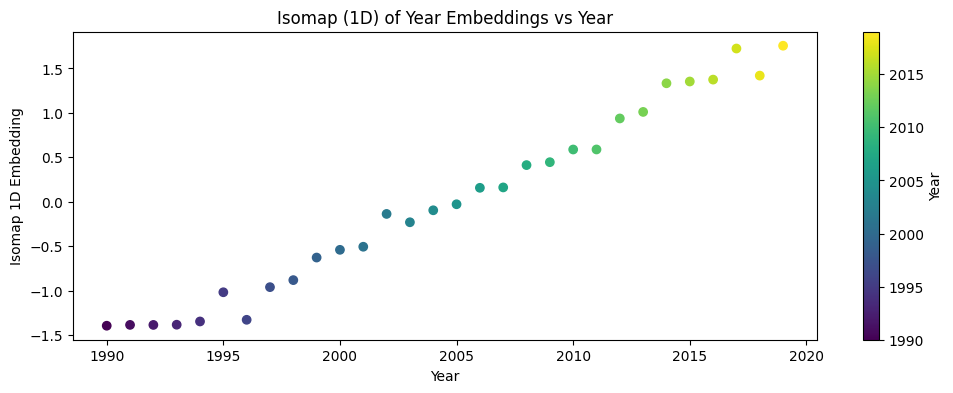

In [7]:
from sklearn.manifold import Isomap

# Assuming year_embeddings is the variable holding the embeddings
isomap = Isomap(n_components=1)
year_isomap_1d = isomap.fit_transform(year_embeddings)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.scatter(years, year_isomap_1d[:, 0], c=years, cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Isomap 1D Embedding')
plt.title('Isomap (1D) of Year Embeddings vs Year')
plt.colorbar(label='Year')
plt.show()


In [8]:
from scipy.stats import kendalltau

# Flatten the isomap embedding to a 1D array
isomap_1d_flat = year_isomap_1d[:, 0]

# Perform Kendall's tau test between the year order and the isomap order
tau, p_value = kendalltau(years, isomap_1d_flat)

print(f"Kendall's tau correlation between year and Isomap 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


Kendall's tau correlation between year and Isomap 1D embedding: 0.9816
P-value: 3.0480e-28
